In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
import json
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler
from utils.results import plot_results, output_correlations
from utils.losses import MSE, MEE

In [2]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [3]:
with open('../report/json/relu.json','r') as fp:
    grid_results = json.load(fp) 

In [6]:
raw_data = np.loadtxt("../../data/Data_set.txt")

data_scaler = StandardScaler()
labels_scaler = StandardScaler(kind = 'vector')

raw_data[:,:-2] = data_scaler.fit_transform(raw_data[:,:-2]) 
raw_data[:,-2:] = labels_scaler.fit_transform(raw_data[:,-2:])

#splitting the data from the labels
data=raw_data[:,:-2]
labels=raw_data[:,-2:]

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)

In [23]:
mypath = '../report/json/'
file = mypath + 'all_dict.json'

with open(file) as json_file:
    f_dict = json.load(json_file)

    
tr_MEE_of_best = []
tr_std_of_best = []
val_MEE_of_best = []
val_std_of_best = []

n_best = 5


for i in range(n_best):
    print(f'\nNetw {i}')
    best_model_dict = grid_results[i]
    best_model_dict['model']
    train_dict = dict(best_model_dict['train'])
    train_dict['verbose'] = True
    #train_dict['epoch'] = 100

    k = 4

    tr_kfold = np.array([])
    val_kfold = np.array([])
    Mse_cand = np.array([])

    for i in range(0,k):
        best_model = MLP_w(**best_model_dict['model'])
        TR_set, VL_set, TR_lab, VL_lab = split(data, labels, kind="k_fold", k = k)
        best_model.train(TR_set, TR_lab , VL_set, VL_lab, **train_dict)
        
        # predict 
        pred_tr = best_model.predict(TR_set)
        pred_val = best_model.predict(VL_set)
        
        # inverse transform of all
        ori_lab_tr = labels_scaler.inverse_transform(TR_lab)
        ori_lab_val = labels_scaler.inverse_transform(VL_lab)
        ori_pred_tr = labels_scaler.inverse_transform(pred_tr)
        ori_pred_val = labels_scaler.inverse_transform(pred_val)
        
        # compute errors
        tr_Err = MEE(ori_lab_tr, ori_pred_tr)
        val_Err = MEE(ori_lab_val, ori_pred_val)
        
        # append to candidate error list
        tr_kfold = np.append(tr_kfold, tr_Err)
        val_kfold = np.append(val_kfold, val_Err)

    print('val error : ',np.mean(val_kfold) ,'+/-' ,np.std(val_kfold))
    print('training error :',np.mean(tr_kfold),'+/-',np.std(tr_kfold))
    
    tr_MEE_of_best.append(np.mean(tr_kfold))
    tr_std_of_best.append(np.std(tr_kfold))
    
    val_MEE_of_best.append(np.mean(val_kfold))
    val_std_of_best.append(np.std(val_kfold))
    
val_MEE_of_best = np.array(val_MEE_of_best)
val_std_of_best = np.array(val_std_of_best)
tr_MEE_of_best = np.array(tr_MEE_of_best)
tr_std_of_best = np.array(tr_std_of_best)


Netw 0
Candidate 0
Epoch 1883:  [train MEE = 0.1525]  [val MEE = 0.1635]                              
Elapsed time: 13.9077627658844 s
Candidate 1
Epoch 1568:  [train MEE = 0.1550]  [val MEE = 0.1648]                              
Elapsed time: 11.51418137550354 s
Candidate 2
Epoch 1504:  [train MEE = 0.1593]  [val MEE = 0.1667]                              
Elapsed time: 11.393048763275146 s
Candidate 0
Epoch 1950:  [train MEE = 0.1500]  [val MEE = 0.1682]                              
Elapsed time: 14.473556756973267 s
Candidate 1
Epoch 2166:  [train MEE = 0.1483]  [val MEE = 0.1665]                              
Elapsed time: 16.607786417007446 s
Candidate 2
Epoch 1770:  [train MEE = 0.1534]  [val MEE = 0.1691]                              
Elapsed time: 13.39599323272705 s
Candidate 0
Epoch 1537:  [train MEE = 0.1531]  [val MEE = 0.1653]                              
Elapsed time: 11.721446752548218 s
Candidate 1
Epoch 1531:  [train MEE = 0.1581]  [val MEE = 0.1679]              

Epoch 1700:  [train MEE = 0.1542]  [val MEE = 0.1653]                              
Elapsed time: 4.417897701263428 s
val error :  1.2192843772934137 +/- 0.04496115894424269
training error : 1.1231904467454306 +/- 0.01134656318294287


In [26]:
for i, (tr, std_tr, v, std_v) in enumerate(zip(tr_MEE_of_best, tr_std_of_best,
                                           val_MEE_of_best, val_std_of_best)):
    print(f'top {i}:')
    print(f'train: {tr:.3f}+-{std_tr:.3f}')
    print(f'val: {v:.3f}+-{std_v:.3f}')

top 0:
train: 1.121+-0.017
val: 1.228+-0.019
top 1:
train: 1.110+-0.040
val: 1.205+-0.020
top 2:
train: 1.124+-0.022
val: 1.209+-0.029
top 3:
train: 1.104+-0.045
val: 1.196+-0.028
top 4:
train: 1.123+-0.011
val: 1.219+-0.045


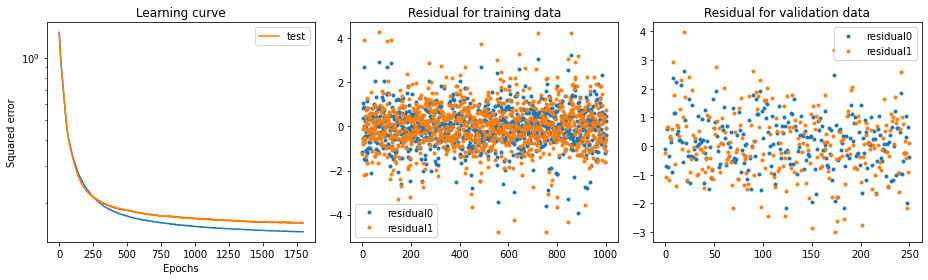

final train error: 1.071691314567273
final val error: 1.179905179451924


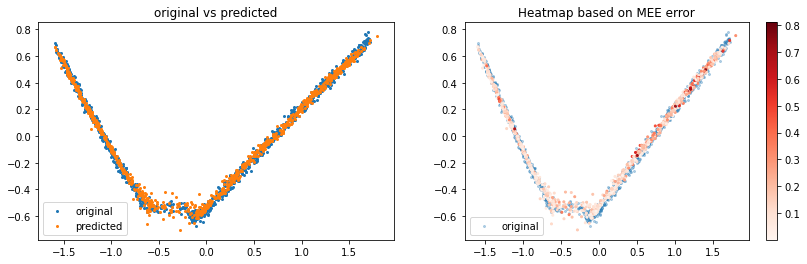

In [9]:
plot_results(best_model, input_data, val_data, train_labels, val_labels, 
             norm = labels_scaler.inverse_transform,
            )
output_correlations(best_model, input_data, train_labels)